In [ ]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
%matplotlib inline
from sklearn.metrics import confusion_matrix

import cv2
import os
import glob


from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_dir = "/content/gdrive/MyDrive/Colab Notebooks/chest_xray/train"
test_dir = "/content/gdrive/MyDrive//Colab Notebooks/chest_xray/test"

print("Train set:\n========================================")
num_bacterial = len(os.listdir(os.path.join(train_dir, 'Bacterial')))
num_viral = len(os.listdir(os.path.join(train_dir, 'Viral')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"bacteria={num_bacterial}")
print(f"virus={num_viral}")
print(f"NORMAL={num_normal}")
print('\n')

print("Test set:\n========================================")
print(f"bacteria={len(os.listdir(os.path.join(test_dir, 'Bacterial')))}")
print(f"virus={len(os.listdir(os.path.join(test_dir, 'Viral')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")
print('\n')


Train set:
bacteria=2531
virus=1345
NORMAL=1341


Test set:
bacteria=242
virus=149
NORMAL=234




In [ ]:
train_normal = Path(train_dir + '/NORMAL').glob('*.jpeg')
train_bacterial = Path(train_dir + '/Bacterial').glob('*.jpeg')
train_viral = Path(train_dir + '/Viral').glob('*.jpeg')

normal_data = [(image, 0) for image in train_normal]
bacterial_data = [(image, 1) for image in train_bacterial]
viral_data = [(image, 2) for image in train_viral]

train_data = normal_data + bacterial_data + viral_data

train_data = pd.DataFrame(train_data, columns=['image', 'label'])

train_data.head()

,image,label
0,/content/gdrive/MyDrive/Colab Notebooks/chest_...,0
1,/content/gdrive/MyDrive/Colab Notebooks/chest_...,0
2,/content/gdrive/MyDrive/Colab Notebooks/chest_...,0
3,/content/gdrive/MyDrive/Colab Notebooks/chest_...,0
4,/content/gdrive/MyDrive/Colab Notebooks/chest_...,0


In [ ]:
train_data.tail()

,image,label
5211,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
5212,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
5213,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
5214,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
5215,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2


In [ ]:
# Shuffle the data
train_data = train_data.sample(frac=1., random_state=100).reset_index(drop=True)

# Checking the dataframe...
train_data.head(10)

,image,label
0,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
1,/content/gdrive/MyDrive/Colab Notebooks/chest_...,1
2,/content/gdrive/MyDrive/Colab Notebooks/chest_...,1
3,/content/gdrive/MyDrive/Colab Notebooks/chest_...,1
4,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
5,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
6,/content/gdrive/MyDrive/Colab Notebooks/chest_...,0
7,/content/gdrive/MyDrive/Colab Notebooks/chest_...,2
8,/content/gdrive/MyDrive/Colab Notebooks/chest_...,1
9,/content/gdrive/MyDrive/Colab Notebooks/chest_...,1


In [ ]:
print(train_data)

                                                  image  label
0     /content/gdrive/MyDrive/Colab Notebooks/chest_...      2
1     /content/gdrive/MyDrive/Colab Notebooks/chest_...      1
2     /content/gdrive/MyDrive/Colab Notebooks/chest_...      1
3     /content/gdrive/MyDrive/Colab Notebooks/chest_...      1
4     /content/gdrive/MyDrive/Colab Notebooks/chest_...      2
...                                                 ...    ...
5211  /content/gdrive/MyDrive/Colab Notebooks/chest_...      2
5212  /content/gdrive/MyDrive/Colab Notebooks/chest_...      1
5213  /content/gdrive/MyDrive/Colab Notebooks/chest_...      0
5214  /content/gdrive/MyDrive/Colab Notebooks/chest_...      0
5215  /content/gdrive/MyDrive/Colab Notebooks/chest_...      2

[5216 rows x 2 columns]


Total of Train Data :  5216   (0 : Normal; 1 : Bacterial 2 : Viral)
1    2530
2    1345
0    1341
Name: label, dtype: int64


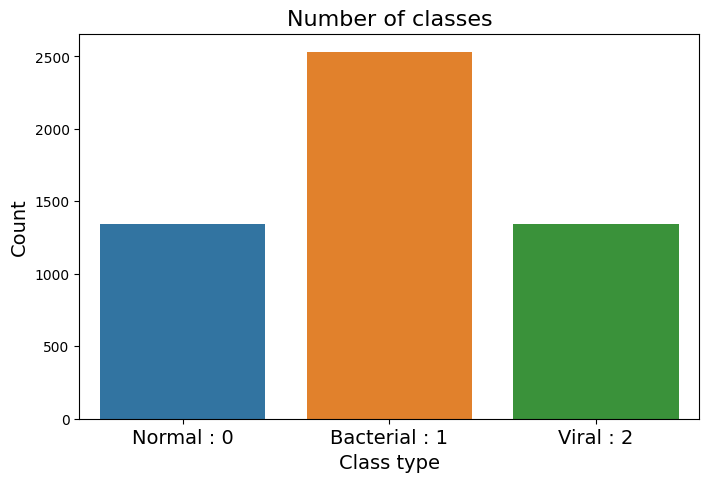

In [ ]:
# Counts for both classes
count_result = train_data['label'].value_counts()
print('Total of Train Data : ', len(train_data), '  (0 : Normal; 1 : Bacterial 2 : Viral)')
print(count_result)

# Plot the results
plt.figure(figsize=(8,5))
sns.countplot(x = 'label', data =  train_data)
plt.title('Number of classes', fontsize=16)
plt.xlabel('Class type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(range(len(count_result.index)),
           ['Normal : 0', 'Bacterial : 1', 'Viral : 2'],
           fontsize=14)
plt.show()

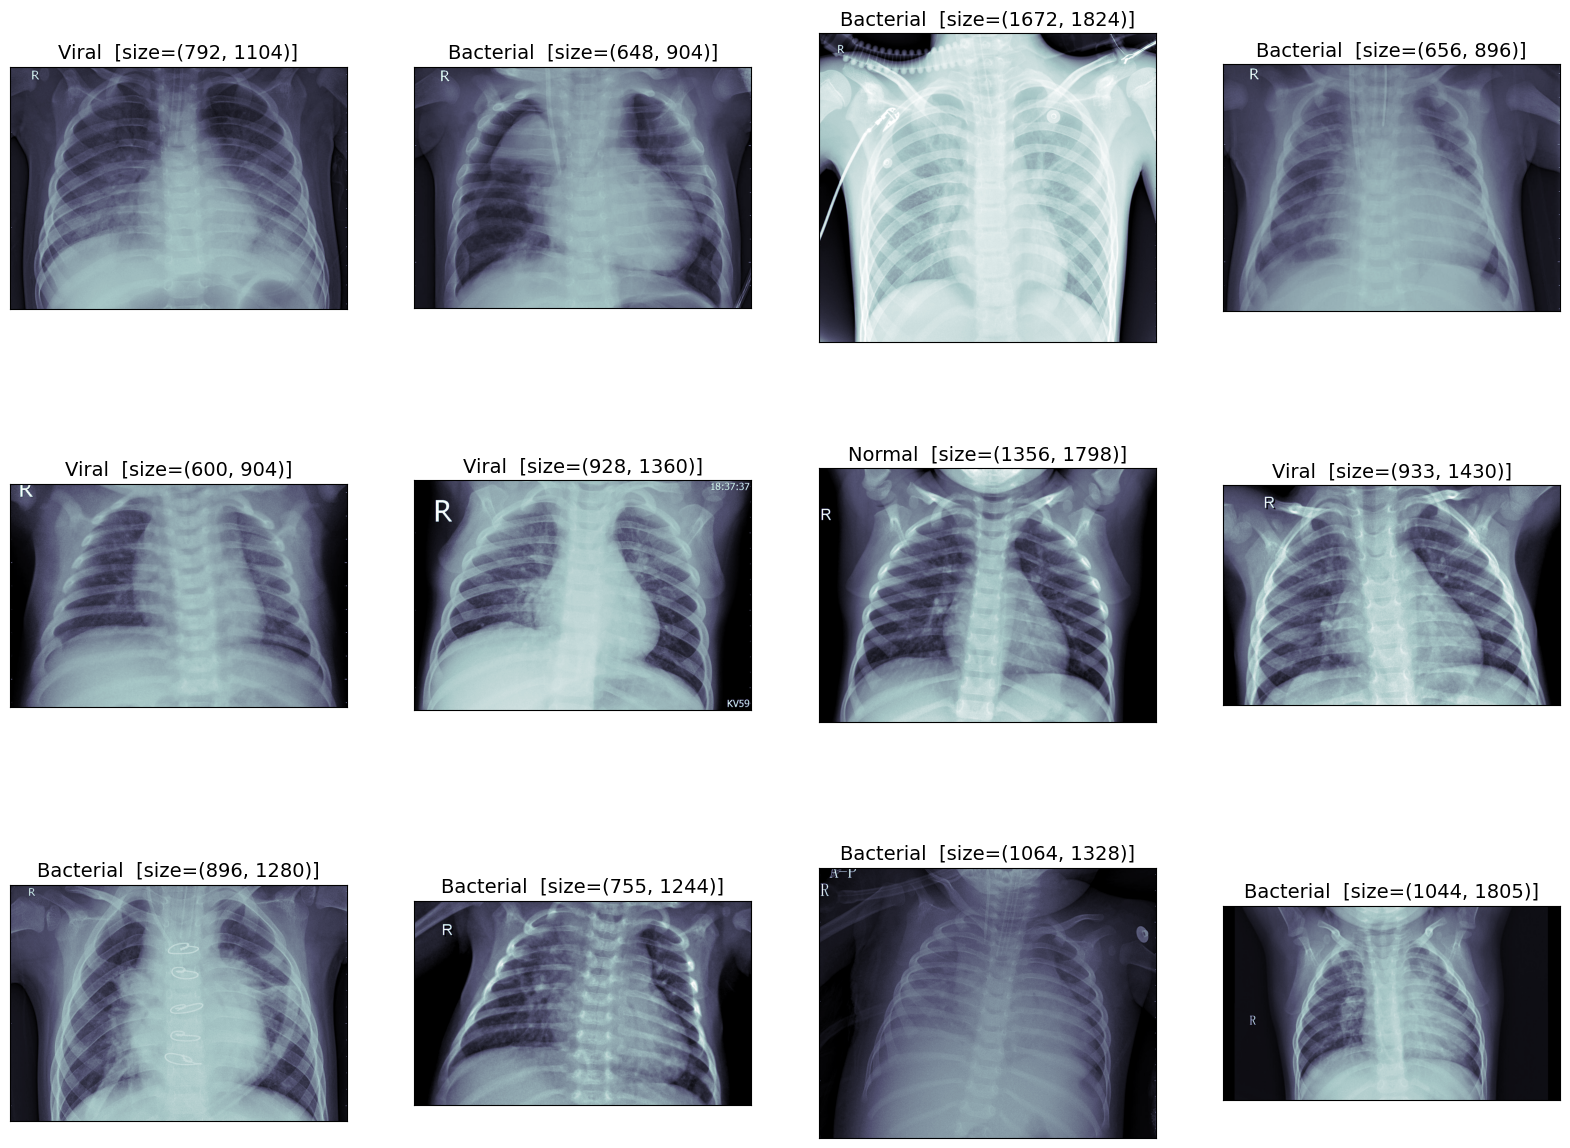

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(20,15))
for i, axi in enumerate(ax.flat):
    image = imread(train_data.image[i])
    label = train_data.label[i]
    if label == 0:
        title_label = 'Normal'
    elif label == 1:
        title_label = 'Bacterial'
    else:
        title_label = 'Viral'

    axi.imshow(image, cmap='bone')
    axi.set_title(title_label + '  [size=' + str(image.shape) +']', fontsize=14)
    axi.set(xticks=[ ], yticks=[ ])


In [ ]:
train_data.to_numpy().shape

(5216, 2)

In [ ]:
batch_size = 16
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)

In [ ]:
class_names = ['NORMAL', 'Bacterial', 'Viral']
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=class_names
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=class_names
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  class_names=class_names
)

Found 5216 files belonging to 3 classes.
Using 4173 files for training.
Found 5216 files belonging to 3 classes.
Using 1043 files for validation.
Found 624 files belonging to 3 classes.


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
print(train_dataset.class_names)

['NORMAL', 'Bacterial', 'Viral']


In [ ]:
for images, labels in train_dataset:

    print(images.shape)  # 輸出批次的形狀
    print(labels)  # 輸出標籤
    break  # 只打印第一個批次，如果想查看後續批次，可以去掉這行


(16, 224, 224, 3)
tf.Tensor([0 2 0 0 1 0 1 1 1 0 2 1 1 2 0 0], shape=(16,), dtype=int32)


In [ ]:
class_counts = [0, 0, 0]  # 初始化每個類別的計數器

for images, labels in test_dataset:
    for label in labels.numpy():  # 將Tensor轉換為numpy array
        class_counts[label] += 1

print("Class 0 count:", class_counts[0])
print("Class 1 count:", class_counts[1])
print("Class 2 count:", class_counts[2])


Class 0 count: 234
Class 1 count: 242
Class 2 count: 148


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_ds = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.05, 0.05),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(20),
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode='vertical')
])

ResNet152V2

In [ ]:
ResNet152V2 = 'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4'
feature_extractor_model_1 = ResNet152V2

In [ ]:
import tensorflow_hub as hub

feature_extractor_layer_1 = hub.KerasLayer(
    feature_extractor_model_1,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
feature_batch_1 = feature_extractor_layer_1(images)
print(feature_batch_1.shape)

(16, 2048)


In [ ]:
model_1 = tf.keras.Sequential([
  feature_extractor_layer_1,
  tf.keras.layers.Dense(3)
])

In [ ]:
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [ ]:
history = model_1.fit(train_dataset,
            validation_data=val_dataset,
            epochs=10)

Epoch 1/10
261/261 [==============================] - 69s 218ms/step - loss: 68.4874 - accuracy: 0.4565 - val_loss: 29.2433 - val_accuracy: 0.6290
Epoch 2/10
261/261 [==============================] - 64s 240ms/step - loss: 36.5438 - accuracy: 0.5548 - val_loss: 140.1541 - val_accuracy: 0.6088
Epoch 3/10
261/261 [==============================] - 53s 201ms/step - loss: 44.0147 - accuracy: 0.5370 - val_loss: 15.6560 - val_accuracy: 0.6779
Epoch 4/10
261/261 [==============================] - 54s 203ms/step - loss: 27.4428 - accuracy: 0.6120 - val_loss: 58.3405 - val_accuracy: 0.3030
Epoch 5/10
261/261 [==============================] - 53s 198ms/step - loss: 36.8710 - accuracy: 0.5847 - val_loss: 80.9416 - val_accuracy: 0.6673
Epoch 6/10
261/261 [==============================] - 54s 203ms/step - loss: 34.2375 - accuracy: 0.5960 - val_loss: 20.9581 - val_accuracy: 0.6213
Epoch 7/10
261/261 [==============================] - 55s 204ms/step - loss: 24.3629 - accuracy: 0.6259 - val_loss: 2

In [ ]:
preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

In [ ]:
IMAGE_SIZE = (img_height, img_width)
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model_1 = tf.keras.applications.ResNet152V2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model_1(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


In [ ]:
base_model_1.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_1(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
output = tf.keras.layers.Dense(3)(x)

model_1 = tf.keras.Model(inputs, output)

In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0   

In [ ]:
base_learning_rate = 0.001
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [ ]:
initial_epochs=10

history = model_1.fit(train_dataset,
          epochs=initial_epochs,
          validation_data=val_dataset)

Epoch 1/10
261/261 [==============================] - 74s 230ms/step - loss: 0.8432 - accuracy: 0.6149 - val_loss: 0.6463 - val_accuracy: 0.7277
Epoch 2/10
261/261 [==============================] - 55s 207ms/step - loss: 0.6844 - accuracy: 0.6990 - val_loss: 0.8613 - val_accuracy: 0.6510
Epoch 3/10
261/261 [==============================] - 58s 219ms/step - loss: 0.6538 - accuracy: 0.7196 - val_loss: 0.6151 - val_accuracy: 0.7373
Epoch 4/10
261/261 [==============================] - 55s 209ms/step - loss: 0.6293 - accuracy: 0.7283 - val_loss: 0.5883 - val_accuracy: 0.7536
Epoch 5/10
261/261 [==============================] - 66s 251ms/step - loss: 0.6206 - accuracy: 0.7354 - val_loss: 0.5962 - val_accuracy: 0.7565
Epoch 6/10
261/261 [==============================] - 58s 216ms/step - loss: 0.6057 - accuracy: 0.7460 - val_loss: 0.5931 - val_accuracy: 0.7392
Epoch 7/10
261/261 [==============================] - 55s 207ms/step - loss: 0.5990 - accuracy: 0.7474 - val_loss: 0.6556 - val_ac

In [ ]:
loss_1, acc_1 = model_1.evaluate(test_dataset)
print('Test loss:', loss_1)
print('Test accuracy:', acc_1)

39/39 [==============================] - 7s 149ms/step - loss: 0.7284 - accuracy: 0.7612
Test loss: 0.7283968329429626
Test accuracy: 0.7612179517745972


In [ ]:
print("Number of layers in the base model: ", len(base_model_1.layers))

Number of layers in the base model:  564


In [ ]:
base_model_1.trainable=True

In [ ]:
fine_tune_at = 450

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_1.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy'])



In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0   

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_1.fit(train_dataset,
              epochs=total_epochs,
              initial_epoch=history.epoch[-1],
              validation_data=val_dataset)

Epoch 10/40
261/261 [==============================] - 90s 261ms/step - loss: 0.6042 - accuracy: 0.7424 - val_loss: 0.6049 - val_accuracy: 0.7498
Epoch 11/40
261/261 [==============================] - 65s 246ms/step - loss: 0.5492 - accuracy: 0.7738 - val_loss: 0.4748 - val_accuracy: 0.8006
Epoch 12/40
261/261 [==============================] - 66s 249ms/step - loss: 0.5172 - accuracy: 0.7865 - val_loss: 0.5197 - val_accuracy: 0.7718
Epoch 13/40
261/261 [==============================] - 66s 249ms/step - loss: 0.5117 - accuracy: 0.7882 - val_loss: 0.4637 - val_accuracy: 0.8025
Epoch 14/40
261/261 [==============================] - 65s 244ms/step - loss: 0.5048 - accuracy: 0.7853 - val_loss: 0.5195 - val_accuracy: 0.7862
Epoch 15/40
261/261 [==============================] - 65s 246ms/step - loss: 0.4823 - accuracy: 0.7906 - val_loss: 0.5571 - val_accuracy: 0.7498
Epoch 16/40
261/261 [==============================] - 64s 242ms/step - loss: 0.4847 - accuracy: 0.7944 - val_loss: 0.6731 -

In [ ]:
loss_1, acc_1 = model_1.evaluate(test_dataset)
print('Test loss:', loss_1)
print('Test accuracy:', acc_1)

39/39 [==============================] - 7s 159ms/step - loss: 0.4196 - accuracy: 0.8702
Test loss: 0.4196110665798187
Test accuracy: 0.870192289352417


MobileNetV2

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model_2 = mobilenet_v2

In [ ]:
import tensorflow_hub as hub

feature_extractor_layer_2 = hub.KerasLayer(
    feature_extractor_model_2,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
model_2 = tf.keras.Sequential([
  feature_extractor_layer_2,
  tf.keras.layers.Dense(3)
])

In [ ]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [ ]:
history = model_2.fit(train_dataset,
            validation_data=val_dataset,
            epochs=10)

Epoch 1/10
261/261 [==============================] - 663s 3s/step - loss: 0.7055 - accuracy: 0.7062 - val_loss: 0.6408 - val_accuracy: 0.7335
Epoch 2/10
261/261 [==============================] - 47s 177ms/step - loss: 0.5945 - accuracy: 0.7534 - val_loss: 0.6448 - val_accuracy: 0.7335
Epoch 3/10
261/261 [==============================] - 46s 175ms/step - loss: 0.5714 - accuracy: 0.7568 - val_loss: 0.6194 - val_accuracy: 0.7498
Epoch 4/10
261/261 [==============================] - 46s 175ms/step - loss: 0.5659 - accuracy: 0.7640 - val_loss: 0.6002 - val_accuracy: 0.7469
Epoch 5/10
261/261 [==============================] - 44s 165ms/step - loss: 0.5373 - accuracy: 0.7779 - val_loss: 0.5873 - val_accuracy: 0.7632
Epoch 6/10
261/261 [==============================] - 46s 175ms/step - loss: 0.5218 - accuracy: 0.7855 - val_loss: 0.5864 - val_accuracy: 0.7613
Epoch 7/10
261/261 [==============================] - 46s 174ms/step - loss: 0.5096 - accuracy: 0.7879 - val_loss: 0.5688 - val_accu

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SIZE = (224, 224)

IMG_SHAPE = IMG_SIZE + (3,)
base_model_2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model_2.trainable = False

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model_2(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32)(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
outputs = tf.keras.layers.Dense(5)(x)

model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
base_learning_rate = 0.0001
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

In [ ]:
initial_epochs = 10
history = model_2.fit(train_dataset,
           epochs=initial_epochs,
           validation_data=val_dataset)

Epoch 1/10
261/261 [==============================] - 61s 199ms/step - loss: 1.3815 - accuracy: 0.3832 - val_loss: 1.2600 - val_accuracy: 0.5120
Epoch 2/10
261/261 [==============================] - 47s 176ms/step - loss: 1.1374 - accuracy: 0.5116 - val_loss: 1.0255 - val_accuracy: 0.6290
Epoch 3/10
261/261 [==============================] - 47s 178ms/step - loss: 0.9654 - accuracy: 0.6048 - val_loss: 0.8856 - val_accuracy: 0.6731
Epoch 4/10
261/261 [==============================] - 47s 178ms/step - loss: 0.8773 - accuracy: 0.6437 - val_loss: 0.8029 - val_accuracy: 0.6922
Epoch 5/10
261/261 [==============================] - 48s 181ms/step - loss: 0.8098 - accuracy: 0.6650 - val_loss: 0.7572 - val_accuracy: 0.6999
Epoch 6/10
261/261 [==============================] - 47s 177ms/step - loss: 0.7635 - accuracy: 0.6753 - val_loss: 0.7286 - val_accuracy: 0.7076
Epoch 7/10
261/261 [==============================] - 47s 176ms/step - loss: 0.7460 - accuracy: 0.6870 - val_loss: 0.6802 - val_ac

In [ ]:
loss_2, acc_2 = model_2.evaluate(test_dataset)
print('Test loss:', loss_2)
print('Test accuracy:', acc_2)

39/39 [==============================] - 4s 86ms/step - loss: 0.7077 - accuracy: 0.7484
Test loss: 0.7077422738075256
Test accuracy: 0.7483974099159241


In [ ]:
base_model_2.trainable = True

fine_tune_at = 90

for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_2.fit(train_dataset,
              epochs=total_epochs,
              initial_epoch=history.epoch[-1],
              validation_data=val_dataset)

Epoch 10/40
261/261 [==============================] - 62s 187ms/step - loss: 0.6694 - accuracy: 0.7184 - val_loss: 0.5831 - val_accuracy: 0.7613
Epoch 11/40
261/261 [==============================] - 48s 181ms/step - loss: 0.6657 - accuracy: 0.7220 - val_loss: 0.7115 - val_accuracy: 0.7239
Epoch 12/40
261/261 [==============================] - 48s 181ms/step - loss: 0.6469 - accuracy: 0.7297 - val_loss: 0.6296 - val_accuracy: 0.7478
Epoch 13/40
261/261 [==============================] - 48s 180ms/step - loss: 0.6257 - accuracy: 0.7419 - val_loss: 0.5944 - val_accuracy: 0.7507
Epoch 14/40
261/261 [==============================] - 48s 180ms/step - loss: 0.6138 - accuracy: 0.7510 - val_loss: 0.5818 - val_accuracy: 0.7440
Epoch 15/40
261/261 [==============================] - 48s 182ms/step - loss: 0.6263 - accuracy: 0.7342 - val_loss: 0.5812 - val_accuracy: 0.7670
Epoch 16/40
261/261 [==============================] - 48s 181ms/step - loss: 0.6035 - accuracy: 0.7513 - val_loss: 0.5647 -

In [ ]:
loss_2, acc_2 = model_2.evaluate(test_dataset)
print('Test loss:', loss_2)
print('Test accuracy:', acc_2)

39/39 [==============================] - 5s 105ms/step - loss: 0.7310 - accuracy: 0.7724
Test loss: 0.7309756278991699
Test accuracy: 0.7724359035491943


# 結論:
在這次專案中我分別使用了ResNet152V2跟MobileNetV2兩個Pre-trained model，由於訓練集資料只有4200筆左右，在兩個模型訓練前都對資料進行了data augmentation，並且為了使資料與模型有更好的結合，在一開始分別針對不同模型盡做了不同的Feature Extraction。從ResNet152V2模型結果來看Fine-Tuning前後有很大的進步，準確度從76%提升到87%。相對之下，MobileNetV2模型的進步較小，只有從74%進步到77%。我認為改變activation function或是optimzer，甚至是增加訓練的epoch都是有機會提升效果的方式。